### Modules

In [1]:
import archives_manager

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

### Functions

In [3]:
def get_player_analysis(player_name, num_games):
    recent_archive = archives_manager.get_most_recent_games(player_name, num_games, time_class='rapid', filter_func=archives_manager.build_archive_filter(rated=True, exclude_draws=True, max_elo_diff=150))

    lst = []

    for archived_game in recent_archive:
        actual = archives_manager.get_won(archived_game, player_name)
        elo = archives_manager.get_elo(archived_game, player_name)

        lst.append({
            'player_name': player_name,
            'unix': archived_game['end_time'],
            'player_elo': elo['Player'],
            'opp_elo': elo['Opponent'],
            'elo_diff': elo['Player'] - elo['Opponent'],
            'won': actual,
            
        })

    df = pd.DataFrame(lst)
    df['ma20'] = df['player_elo'].rolling(window=20).mean()
    df['ma5'] = df['player_elo'].rolling(window=5).mean()
    df['x-ma20'] = df['player_elo'] - df['ma20']
    df['x-ma5'] = df['player_elo'] - df['ma5']
    df['ma5-ma20'] = df['ma5'] - df['ma20']

    return df, recent_archive

### Data Gathering/Compiling

In [4]:
num_games_per_player = 1000

analyses = []
stats_list = []

players = [
    'BIG_TONKA_T',
    'UnderTheBeer',
    'Dandres0_0',
    'Ale9800',
    'MrOGH'
]

for player_name in players:
    df, recent_archive = get_player_analysis(player_name, num_games=num_games_per_player)
    
    player_info = {
        'Name': player_name,
        'Current Rating': archives_manager.get_elo(recent_archive[0], player_name)['Player'],
    }
    
    analyses.append({
        'player_name': player_name,
        'stats': player_info,
        'data': df,
        'archive': recent_archive
    })
    
data_list = [analysis['data'] for analysis in analyses]
df = pd.concat(data_list)
    
df = df.dropna().reset_index()

In [5]:
df.head(5)

,index,player_name,unix,player_elo,opp_elo,elo_diff,won,ma20,ma5,x-ma20,x-ma5,ma5-ma20
0,19,BIG_TONKA_T,1696883751,1382,1321,61,1,1389.60,1399.2,-7.60,-17.2,9.60
1,20,BIG_TONKA_T,1696884794,1389,1419,-30,1,1391.80,1393.8,-2.80,-4.8,2.00
2,21,BIG_TONKA_T,1696885872,1398,1448,-50,0,1394.10,1392.0,3.90,6.0,-2.10
3,22,BIG_TONKA_T,1696886809,1391,1356,35,1,1395.65,1390.2,-4.65,0.8,-5.45
4,23,BIG_TONKA_T,1696887440,1398,1436,-38,0,1397.15,1391.6,0.85,6.4,-5.55


### Logistic Regression

In [6]:
X = df[['elo_diff']]  # Predictor
y = df['won']         # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.4961580680570801
              precision    recall  f1-score   support

           0       0.48      0.38      0.42       448
           1       0.50      0.61      0.55       463

    accuracy                           0.50       911
   macro avg       0.49      0.49      0.49       911
weighted avg       0.49      0.50      0.49       911



In [7]:
X = df[['elo_diff', 'x-ma20']]  # Predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.5049396267837541
              precision    recall  f1-score   support

           0       0.50      0.42      0.45       448
           1       0.51      0.59      0.55       463

    accuracy                           0.50       911
   macro avg       0.50      0.50      0.50       911
weighted avg       0.50      0.50      0.50       911



0.5049396267837541
              precision    recall  f1-score   support

           0       0.50      0.42      0.45       448
           1       0.51      0.59      0.55       463

    accuracy                           0.50       911
   macro avg       0.50      0.50      0.50       911
weighted avg       0.50      0.50      0.50       911



<Figure size 1000x800 with 0 Axes>

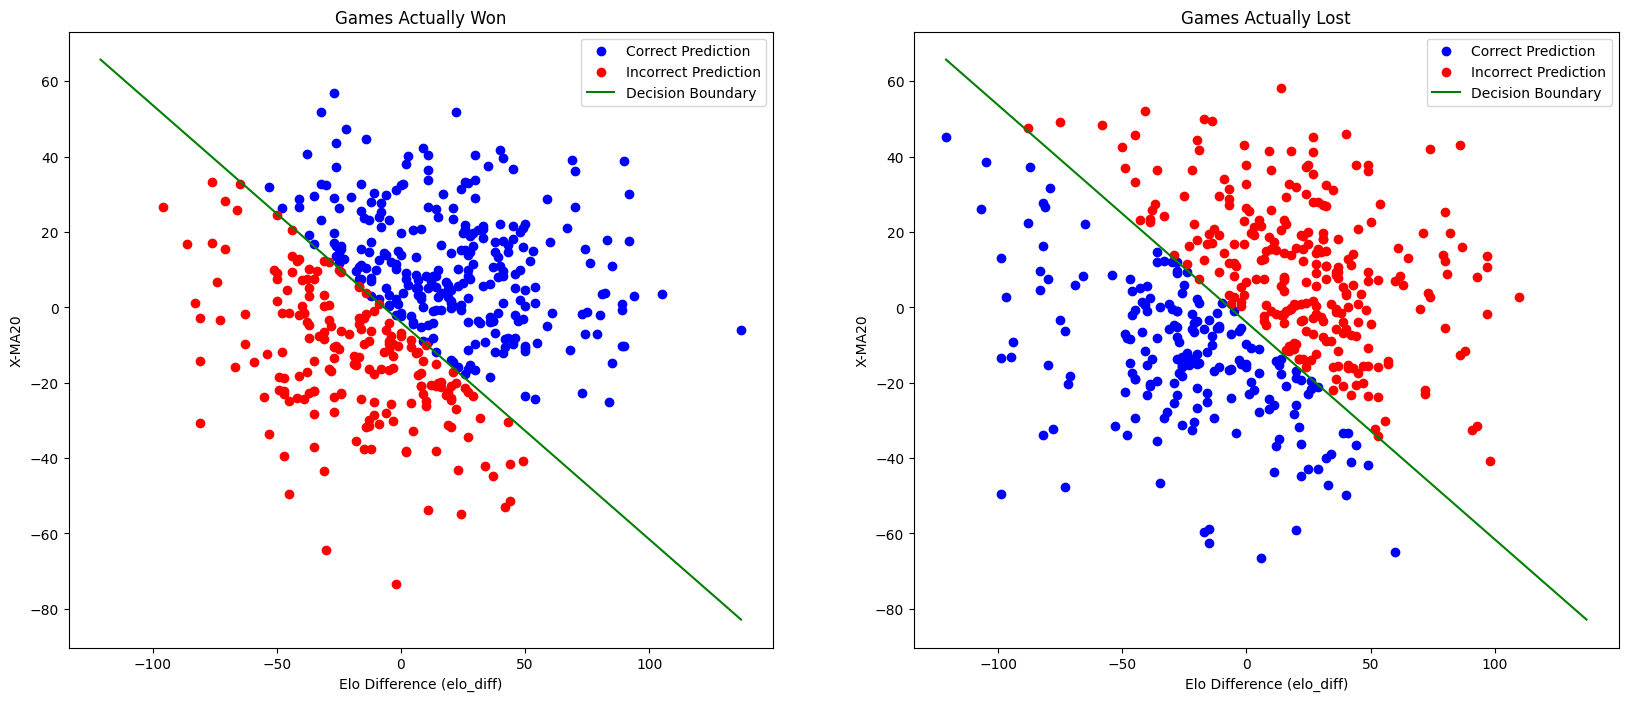

In [8]:
X = df[['elo_diff', 'x-ma20']]  # Predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))

# Set up a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Adding a logit line
coef = model.coef_[0]
intercept = model.intercept_

# Create a grid of values
x_values = np.linspace(X_test['elo_diff'].min(), X_test['elo_diff'].max())
# Calculate the decision boundary (this is for a binary classifier with a 0.5 threshold)
y_values = -(intercept + coef[0] * x_values) / coef[1]

# Games actually won
actually_won = y_test == 1
correct_predictions_won = (predictions == y_test) & actually_won
incorrect_predictions_won = (predictions != y_test) & actually_won

ax1.scatter(X_test.loc[correct_predictions_won, 'elo_diff'], X_test.loc[correct_predictions_won, 'x-ma20'], 
            color='blue', label='Correct Prediction')
ax1.scatter(X_test.loc[incorrect_predictions_won, 'elo_diff'], X_test.loc[incorrect_predictions_won, 'x-ma20'], 
            color='red', label='Incorrect Prediction')
ax1.plot(x_values, y_values, label='Decision Boundary', color='green')
ax1.set_title('Games Actually Won')
ax1.set_xlabel('Elo Difference (elo_diff)')
ax1.set_ylabel('X-MA20')
ax1.legend()

# Games actually lost
actually_lost = y_test == 0
correct_predictions_lost = (predictions == y_test) & actually_lost
incorrect_predictions_lost = (predictions != y_test) & actually_lost

ax2.scatter(X_test.loc[correct_predictions_lost, 'elo_diff'], X_test.loc[correct_predictions_lost, 'x-ma20'], 
            color='blue', label='Correct Prediction')
ax2.scatter(X_test.loc[incorrect_predictions_lost, 'elo_diff'], X_test.loc[incorrect_predictions_lost, 'x-ma20'], 
            color='red', label='Incorrect Prediction')
ax2.plot(x_values, y_values, label='Decision Boundary', color='green')
ax2.set_title('Games Actually Lost')
ax2.set_xlabel('Elo Difference (elo_diff)')
ax2.set_ylabel('X-MA20')
ax2.legend()

# Display the plots
plt.show()

In [9]:
X = df[['elo_diff', 'x-ma5']]  # Predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.5159165751920965
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       448
           1       0.52      0.61      0.56       463

    accuracy                           0.52       911
   macro avg       0.51      0.51      0.51       911
weighted avg       0.51      0.52      0.51       911



0.5159165751920965
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       448
           1       0.52      0.61      0.56       463

    accuracy                           0.52       911
   macro avg       0.51      0.51      0.51       911
weighted avg       0.51      0.52      0.51       911



<Figure size 1000x800 with 0 Axes>

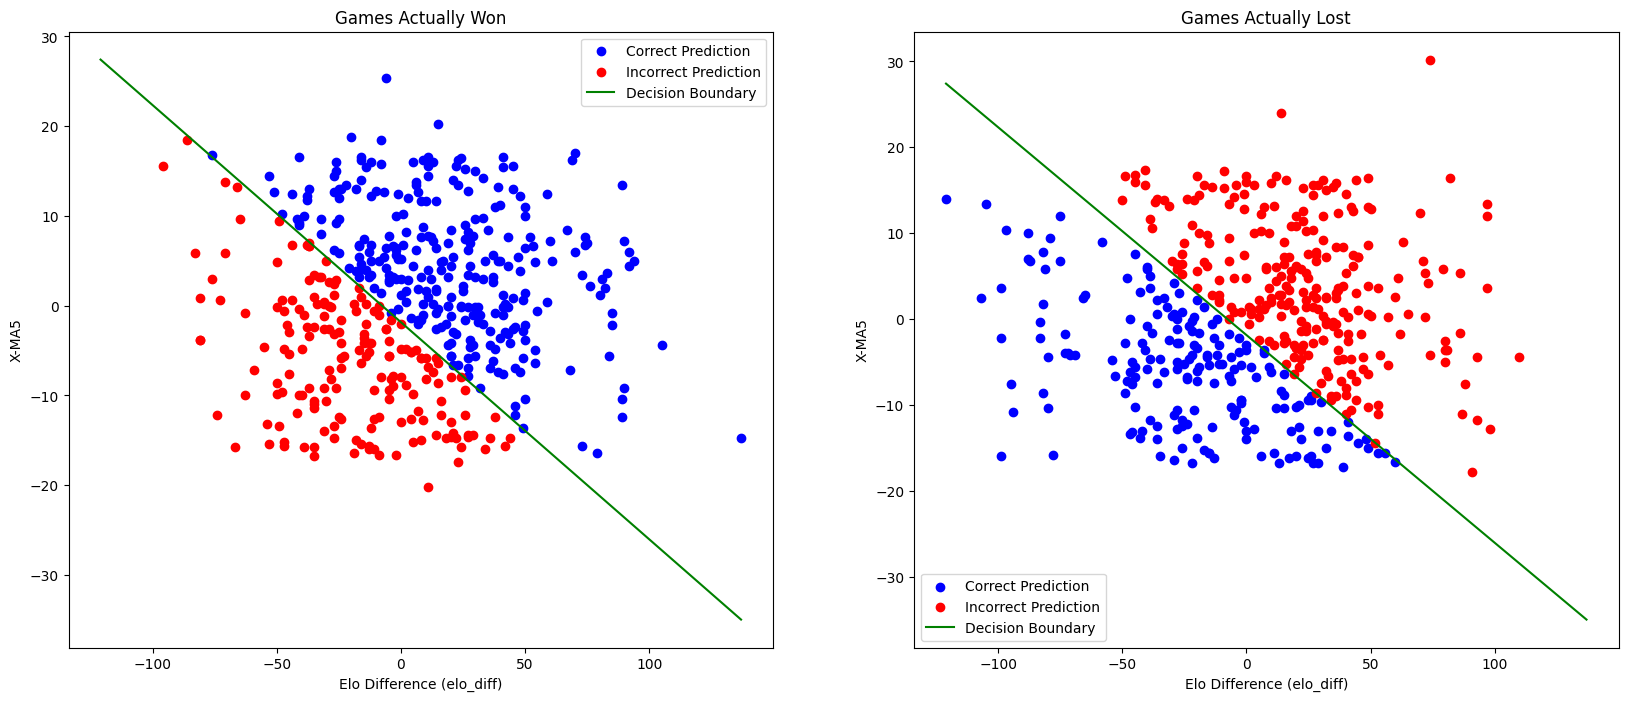

In [10]:
X = df[['elo_diff', 'x-ma5']]  # Predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))

# Set up a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Adding a logit line
coef = model.coef_[0]
intercept = model.intercept_

# Create a grid of values
x_values = np.linspace(X_test['elo_diff'].min(), X_test['elo_diff'].max())
# Calculate the decision boundary (this is for a binary classifier with a 0.5 threshold)
y_values = -(intercept + coef[0] * x_values) / coef[1]

# Games actually won
actually_won = y_test == 1
correct_predictions_won = (predictions == y_test) & actually_won
incorrect_predictions_won = (predictions != y_test) & actually_won

ax1.scatter(X_test.loc[correct_predictions_won, 'elo_diff'], X_test.loc[correct_predictions_won, 'x-ma5'], 
            color='blue', label='Correct Prediction')
ax1.scatter(X_test.loc[incorrect_predictions_won, 'elo_diff'], X_test.loc[incorrect_predictions_won, 'x-ma5'], 
            color='red', label='Incorrect Prediction')
ax1.plot(x_values, y_values, label='Decision Boundary', color='green')
ax1.set_title('Games Actually Won')
ax1.set_xlabel('Elo Difference (elo_diff)')
ax1.set_ylabel('X-MA5')
ax1.legend()

# Games actually lost
actually_lost = y_test == 0
correct_predictions_lost = (predictions == y_test) & actually_lost
incorrect_predictions_lost = (predictions != y_test) & actually_lost

ax2.scatter(X_test.loc[correct_predictions_lost, 'elo_diff'], X_test.loc[correct_predictions_lost, 'x-ma5'], 
            color='blue', label='Correct Prediction')
ax2.scatter(X_test.loc[incorrect_predictions_lost, 'elo_diff'], X_test.loc[incorrect_predictions_lost, 'x-ma5'], 
            color='red', label='Incorrect Prediction')
ax2.plot(x_values, y_values, label='Decision Boundary', color='green')
ax2.set_title('Games Actually Lost')
ax2.set_xlabel('Elo Difference (elo_diff)')
ax2.set_ylabel('X-MA5')
ax2.legend()

# Display the plots
plt.show()

In [11]:
df['interaction'] = df['x-ma20'] * df['x-ma5']
X = df[['elo_diff', 'x-ma20', 'interaction']]  # Predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.5214050493962679
              precision    recall  f1-score   support

           0       0.52      0.40      0.45       448
           1       0.52      0.63      0.57       463

    accuracy                           0.52       911
   macro avg       0.52      0.52      0.51       911
weighted avg       0.52      0.52      0.51       911

